# Load DBPedia dataset

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/dbpedia_14")
CLASS_LABELS = ds['train'].features['label'].names
CLASS_LABELS

# Obtain first n samples from each class

In [ ]:
import numpy as np

In [ ]:
def get_n_samples_per_class(dataset, n, shuffle = False):
    """
        Given a test dataset, select n samples from each class
        and return a smaller dataset containing all the samples.

        Args:
            dataset (Dataset): The test dataset to sample.
            n (int): How many samples from each class to extract.
            shuffle (bool): Whether to sort the final result by class or randomly. NOTE: Dataset.shuffle() hangs indefinitely on Nix.

        Returns:
            sample (Dataset): The sampled dataset.
    """
    ds_sorted = dataset.sort('label')
    _, class_indices = np.unique(ds_sorted['label'], return_index=True)


    class_indices = np.array([list(range(index, index + n)) for index in class_indices])
    class_indices = class_indices.flatten()

    if shuffle:
        sample = dataset.shuffle().sort('label').select(class_indices) # Dataset.shuffle() hangs indefinitely on Nix - No idea why.
    else:
        sample = dataset.sort('label').select(class_indices)

    if shuffle: sample = sample.shuffle() # Dataset.shuffle() hangs indefinitely on Nix - No idea why.
    return sample

In [78]:
small_dataset = get_n_samples_per_class(ds['test'], 10, shuffle=False)

# Prompt to classify articles

In [ ]:
# Zero-shot prompt to classify articles and return their category ID.
PROMPT_ZEROSHOT = """You are an expert in classifying articles into categories.
Your task is to read an article, decide which category it belongs into, and then return the number of that category.
There are 14 categories you may choose from, but you can only decide one category.

CATEGORIES:
0. Company
1. Educational Institution
2. Artist
3. Athlete
4. Office Holder
5. Method Of Transportation
6. Building
7. Natural Place
8. Village
9. Animal
10. Plant
11. Album
12. Film
13. Written Work

Read the following article and return the most suitable category as a number ("0"), NOT as text ("Company").
"""

# Zero-shot chain-of-thought prompt to classify articles and return their category name.
PROMPT_COT = """You are an expert at classifying articles into the following categories:

CATEGORIES:
0. Company
1. Educational Institution
2. Artist
3. Athlete
4. Office Holder
5. Method Of Transportation
6. Building
7. Natural Place
8. Village
9. Animal
10. Plant
11. Album
12. Film
13. Written Work

Read the following article and explain which category describes its content best.
End your answer with the category name.
Let's think step by step.
"""

PROMPT_FEWSHOT_COT = """You are an expert at classifying articles into the following categories:

CATEGORIES:
0. Company
1. Educational Institution
2. Artist
3. Athlete
4. Office Holder
5. Method Of Transportation
6. Building
7. Natural Place
8. Village
9. Animal
10. Plant
11. Album
12. Film
13. Written Work

Read the following article and explain which category describes its content best.
End your answer with the category name.
Let's think step by step.


"""

In [ ]:
def get_classification_prompt(article, prompt):
    """
      For a given article in the Dataset,
      return a LLM prompt in chat template form
      to get its category.

      Args:
          article (Dictionary): Any item in the dataset.
          prompt (str): A model prompt with article classification instructions.

      Returns:
          prompt (Dictionary): The prompt as a [Chat Template](https://huggingface.co/docs/transformers/main/en/chat_templating).
    """
    return [
      {"role": "system", "content": prompt},
      {"role": "user", "content": article["content"].strip()},
    ]

# Load LLM

To access the LLM (C4AI Command R7B), you will need to accept a license agreement on Hugging Face.

STEPS:
1. Log into hugging face
2. Accept the license agreement [here](https://huggingface.co/CohereForAI/c4ai-command-r7b-12-2024)
3. Replace variable ``YOUR_HF_TOKEN`` with your Hugging Face token.

In [ ]:
HF_TOKEN = ""

In [ ]:
from accelerate.test_utils.testing import get_backend

DEVICE, _, _ = get_backend()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "CohereForAI/c4ai-command-r7b-12-2024"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN, device_map="auto")
model = AutoModelForCausalLM.from_pretrained(model_id, token=HF_TOKEN, device_map="auto")

In [ ]:
import transformers, torch

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    token=HF_TOKEN,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Model testing method

In [44]:
LABEL_NAMES=[
    "Company",
    "Educational Institution",
    "Artist",
    "Athlete",
    "Office Holder",
    "Method Of Transportation",
    "Building",
    "Natural Place",
    "Village",
    "Animal",
    "Plant",
    "Album",
    "Film",
    "Written Work"
]

In [42]:
import random
import re

LABEL_NAMES=[
    "Company",
    "Educational Institution",
    "Artist",
    "Athlete",
    "Office Holder",
    "Method Of Transportation",
    "Building",
    "Natural Place",
    "Village",
    "Animal",
    "Plant",
    "Album",
    "Film",
    "Written Work"
]

def get_class_label_from_string(string, class_labels = LABEL_NAMES):
    """
    Extract a class label by name from a string and return its ID.
    If no match is found, choose a random label ID.
    
    Args:
    string (str): A string containing the name of one class label.
    
    Returns:
    class_id (int): The ID of the matching class label.
    """
    string = string.lower().strip()

    # Concatenate all label names using boolean OR.
    match = "|".join(LABEL_NAMES).lower().replace(" ", r"\s*")

    # Find all instances of label name strings within the base string.
    matches = re.findall(match, string)

    # If no class label is found in the LLM text, pick a random label.
    if matches == []:
        print(f"No class label found in string: {string}")
        return random.randint(0, len(LABEL_NAMES))

    # Get the last matching label from the string.
    final_match = matches[-1]

    # Remove all capitalisation, non-alphabetic characters, and whitespace
    labels_sanitised = [re.sub("[^a-z]", "", label.lower()) for label in LABEL_NAMES]
    match_sanitised = re.sub("[^a-z]", "", final_match.lower())

    # Find the matching class ID for the label.
    class_id = labels_sanitised.index(match_sanitised)
    return class_id

In [97]:
import re

def get_first_number_from_string(string):
  """
  Returns the first whole number from a string as an integer.
  """
  first_number=re.findall(r"\d+",string)
  if first_number is not None:
    first_number = int(first_number[0])
    return first_number
  else:
    raise Exception(f"No number found in string: {string}")

def get_category_label(article, classification_prompt, extractor_func, max_tokens = 10):
  """
  For a given article in the DBPedia dataset, predict its category label.

  Args:
    article (str): Article contents as raw text.
    classifiction_prompt (str): Model instructions on how to classify articles.
    extractor_func (func): A method which takes the model's response and returns a classification label as an integer.
    max_tokens (int): Model response word limit.

  Returns:
    output (tuple<int, str>): The category of the article and the raw LLM output.
  """
  input = get_classification_prompt(article, classification_prompt)

  chat_history = pipeline(
      input,
      do_sample=True,
      #top_k=10,
      #num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
      max_new_tokens=max_tokens,
      temperature=0.001
      #continue_final_message=continue_final_message
  )

  response = chat_history[0]["generated_text"][-1]['content']

  class_id = extractor_func(response)

  return (class_id, response)

In [98]:
from tqdm import tqdm

def predict_classes(dataset, classification_prompt, extractor_func, max_tokens):
  """
    For a given RFPedia dataset, use the contents of each article to predict its label.

    Args:
      dataset (Dataset): The dataset to sample.
      classifiction_prompt (str): Model instructions on how to classify articles.
      extractor_func (func): A method which takes the model's response and returns a classification label as an integer.
      max_tokens (int): Model response word limit.

    Returns:
      results (tuple<list, list, list>):
        y_pred (list<int>): Predicted labels
        y_true (list<int>): Actual labels (groundtruth)
        responses (list<str>): Raw LLM response for each test sample.
  """
  y_pred = []
  y_true = []
  responses = []

  for item in tqdm(dataset, "Classifying articles"):

    pred_label, response = get_category_label(item, classification_prompt, extractor_func, max_tokens)

    y_pred.append( pred_label )
    y_true.append( item['label' ])
    responses.append( response )

  return y_pred, y_true, responses

# Test the model

In [99]:
configurations = [
    {"name" : "Zero-shot",
     "prompt" : PROMPT_ZEROSHOT,
     "max_tokens" : 10,
     "extractor_func" : get_first_number_from_string},

    {"name" : "Chain-of-Thought",
     "prompt" : PROMPT_COT,
     "max_tokens" : 100,
     "extractor_func" : get_class_label_from_string}
]

In [100]:
# Predict all article categories in the dataset

y_true = None
test_data = small_dataset

for config in tqdm(configurations, "Testing LLM configurations"):

  args = config['prompt'], config['extractor_func'], config['max_tokens']

  config['y_pred'], config['y_true'], config['responses'] = predict_classes(test_data, *args)

Classifying articles:  43%|████▎     | 60/140 [02:55<05:21,  4.02s/it]

No class label found in string: the two-point-six replaced the riley pathfinder as riley's top-line automobile. while its predecessor retained the riley 4 cylinder twin cam cross flow engine the two-point-six was almost identical to the wolseley six-ninety series iii.

this text describes the evolution of a specific automobile model, focusing on the transition from the riley pathfinder to the two-point-six. it highlights the continuity in the engine type (riley 4 cylinder twin cam cross flow) while



Testing LLM configurations: 100%|██████████| 2/2 [08:22<00:00, 251.40s/it]


# Evaluate the model

## Accuracy report + confusion matrix

In [106]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import pandas as pd
import os

def evaluate_model(config):
  """
  Evaluate a model configuration and save the results to output_dir.
  """

  output_dir = os.path.join("output", config['name'].replace(' ', '_').lower())
  os.makedirs(output_dir, exist_ok=True)

  y_true, y_pred, config_name = config['y_true'], config['y_pred'], config['name']
  print(f"\n{config_name} evaluation results\n")

  # Get precision, recall, and F1 score
  classif_report = classification_report(y_true, y_pred, zero_division=0.0, output_dict=True)
  classif_report = pd.DataFrame(classif_report).transpose()

  # Save classification report to output dir
  classif_report.to_csv( os.path.join(output_dir, "evaluation.csv"), escapechar='\\' )

  # Display confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
      y_true, y_pred,
      display_labels = CLASS_LABELS,
      cmap = plt.cm.Blues,
      xticks_rotation='vertical')
  disp.ax_.set_title(config_name)

  # Save confusion matrix to output dir
  disp.plot().figure_.savefig( os.path.join(output_dir, 'confusion_matrix.png') )


Zero-shot evaluation results


Chain-of-Thought evaluation results



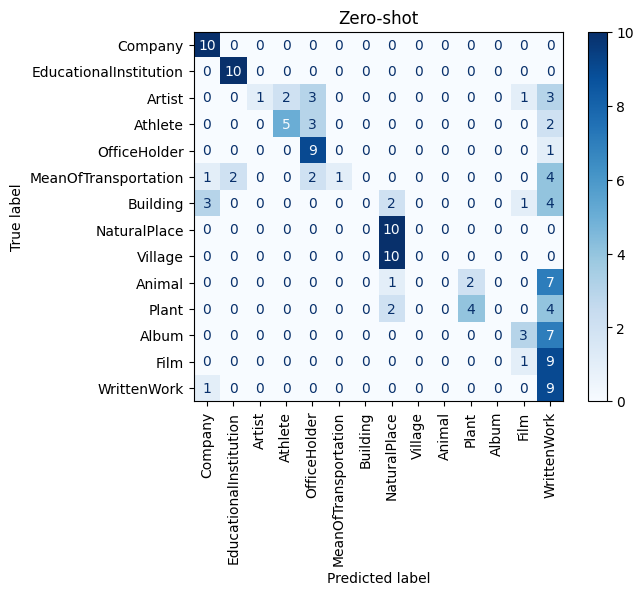

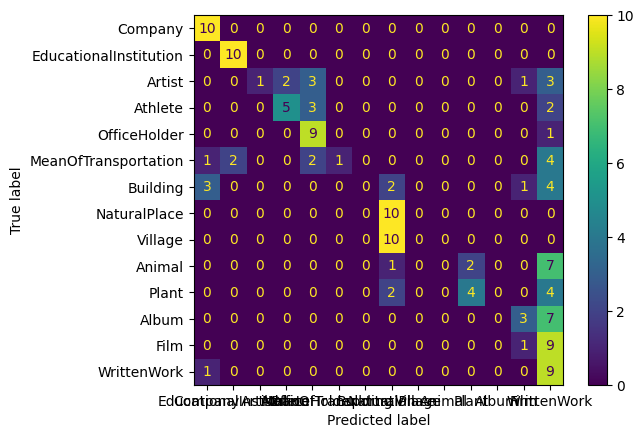

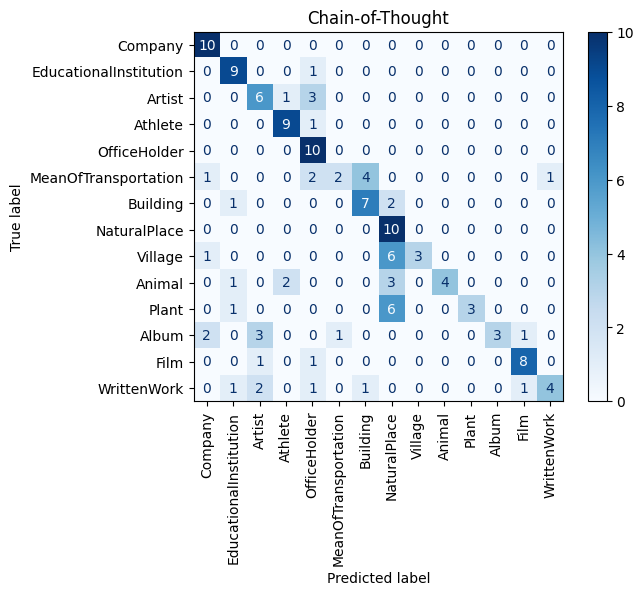

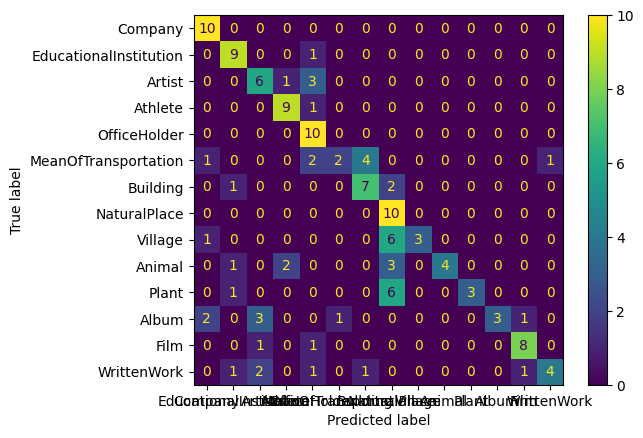

In [107]:
for config in configurations:
  evaluate_model(config)

## Get all incorrect LLM responses

In [109]:
def get_incorrect_answers(config):
  output_dir = os.path.join("output", config['name'].replace(' ', '_').lower())

  # Get a boolean mask for every incorrect prediction
  incorrect = np.array(config['y_pred']) != np.array(config['y_true'])

  # Get the index of every incorrect prediction
  index = np.array(list(range(test_data.num_rows)))[incorrect]

  # Get every incorrect predicted label
  incorrect_labels = np.array(config['y_pred'])[incorrect]

  incorrect_answers = {
      # Obtain title and content of article
      "Title" : np.array([item['title'] for item in test_data])[incorrect],
      "Content" : np.array([item['content'] for item in test_data])[incorrect],

      # Get the class names for y_pred and y_true
      "Predicted Category" : [CLASS_LABELS[id] for id in np.array(config['y_pred'])[incorrect]],
      "Actual Category" : [CLASS_LABELS[id] for id in np.array([item['label'] for item in test_data])[incorrect]],

      # Get LLM raw text output
      "LLM Output" : np.array(config['responses'])[incorrect]
  }

  incorrect_answers = pd.DataFrame(incorrect_answers, index=index)

  incorrect_answers.to_csv( os.path.join(output_dir, "incorrect_answers.csv"), escapechar='\\' )

  return incorrect_answers

In [110]:
for config in configurations:
  get_incorrect_answers(config)